In [18]:
import requests
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

In [19]:
load_dotenv()

True

In [23]:
def fetch_news(api_key, query, sources=None, language='en', page_size=100):
    """
    Fetches news articles from the News API based on the given query and optional parameters.
    
    Parameters:
    - api_key: Your News API key.
    - query: The search query for news articles.
    - sources: Optional. A comma-separated string of news sources to filter results from.
    - language: Optional. The language for the news articles (default is 'en' for English).
    - page_size: Optional. The number of articles to retrieve per request (maximum is 100).
    
    Returns:
    - A list of dictionaries, each containing information about a news article.
    """
    url = 'https://newsapi.org/v2/everything'
    params = {
        'apiKey': api_key,
        'q': query,
        'sources': sources,
        'language': language,
        'pageSize': page_size
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    if response.status_code == 200:
        articles = data.get('articles', [])
        df = pd.DataFrame(articles)
        # Extract relevant columns
        df = df[['title', 'description', 'source', 'publishedAt', 'url']]
        # Rename columns
        df.columns = ['title', 'description', 'source', 'published_at', 'url']
        # Convert published_at to datetime format
        df['published_at'] = pd.to_datetime(df['published_at'])
        return df
    else:
        print("Failed to fetch news:", data.get('message', 'Unknown error'))
        return pd.DataFrame()

# Replace 'YOUR_API_KEY' with your actual News API key
api_key = os.environ['API_KEY']
query = 'business OR finance'  # You can adjust the query as needed
sources = None  # You can specify specific news sources if desired

# Fetch news articles as a DataFrame
news_df = fetch_news(api_key, query, sources)

# Display the DataFrame
news_df.sort_values(by=['published_at'], ascending=False)


,title,description,source,published_at,url
59,Google’s new AI will play video games with you...,Google DeepMind’s AI agent SIMA is learning ho...,"{'id': 'the-verge', 'name': 'The Verge'}",2024-03-13 14:00:00+00:00,https://www.theverge.com/2024/3/13/24099024/go...
60,Nvidia could be worth $6 trillion if it follow...,Nvidia is already worth $2.3 trillion and form...,"{'id': 'business-insider', 'name': 'Business I...",2024-03-13 12:33:17+00:00,https://www.businessinsider.com/nvidia-stock-p...
84,TikTok influencers fear their careers will be ...,TikTokers spoke to Business Insider about the ...,"{'id': 'business-insider', 'name': 'Business I...",2024-03-12 16:57:16+00:00,https://www.businessinsider.com/tiktok-ban-inf...
65,The Morning After: Airbnb bans indoor cameras,Airbnb has announced a complete ban on indoor ...,"{'id': None, 'name': 'Yahoo Entertainment'}",2024-03-12 11:15:36+00:00,https://consent.yahoo.com/v2/collectConsent?se...
83,British Airways is upgrading its long-haul fle...,British Airways is retrofitting more of its lo...,"{'id': 'business-insider', 'name': 'Business I...",2024-03-12 09:00:01+00:00,https://www.businessinsider.com/british-airway...
...,...,...,...,...,...
81,The richest man you've never heard of isn't su...,Autry Stephens is one of the world's 100 riche...,"{'id': 'business-insider', 'name': 'Business I...",2024-02-15 10:00:01+00:00,https://www.businessinsider.com/endeavor-energ...
38,A woman who quit her job to travel says she re...,"In an article for CNBC, Helen Zhao wrote that ...","{'id': 'business-insider', 'name': 'Business I...",2024-02-15 05:53:25+00:00,https://www.businessinsider.com/woman-traveler...
54,SpaceX files to relocate to Texas after Elon M...,Elon Musk vowed to take Space X's business out...,"{'id': 'business-insider', 'name': 'Business I...",2024-02-15 01:21:49+00:00,https://www.businessinsider.com/spacex-relocat...
27,Stability AI tries to stay ahead of the pack w...,Stability AI promises Stable Cascade generates...,"{'id': 'the-verge', 'name': 'The Verge'}",2024-02-14 23:13:48+00:00,https://www.theverge.com/2024/2/14/24073253/st...


In [4]:
news_df.shape

(100, 5)

In [5]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   title         100 non-null    object             
 1   description   99 non-null     object             
 2   source        100 non-null    object             
 3   published_at  100 non-null    datetime64[ns, UTC]
 4   url           100 non-null    object             
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 4.0+ KB


In [6]:
news_df.dropna(inplace=True)

In [7]:
# Distribution of post titles and selftexts lengths
news_df['title_length'] = news_df['title'].apply(len)
news_df['description_length'] = news_df['description'].apply(len)

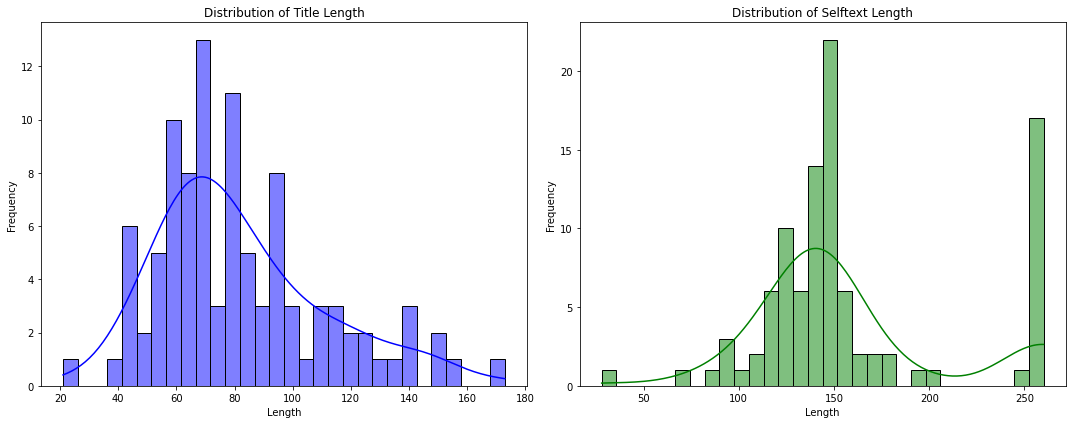

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the distribution of title length
sns.histplot(news_df['title_length'], bins=30, kde=True, color='blue', ax=axes[0])
axes[0].set_title('Distribution of Title Length')
axes[0].set_xlabel('Length')
axes[0].set_ylabel('Frequency')

# Plot the distribution of selftext length
sns.histplot(news_df['description_length'], bins=30, kde=True, color='green', ax=axes[1])
axes[1].set_title('Distribution of Selftext Length')
axes[1].set_xlabel('Length')
axes[1].set_ylabel('Frequency')
    
plt.tight_layout()
plt.show()

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
stop_words = set(stopwords.words('english'))

In [11]:
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Convert to lowercase
    tokens = [word.lower() for word in tokens]
    # Removing Punctuation
    table = str.maketrans('', '', string.punctuation)
    stripped = [word.translate(table) for word in tokens]
    # Removing Stopwords
    words = [word for word in stripped if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    # Join the lemmatized words back into a string
    processed_text = ' '.join(lemmatized_words)
    return processed_text

In [12]:
news_df['title'] = news_df['title'].apply(preprocess_text)
news_df['description'] = news_df['description'].apply(preprocess_text)

# Save the preprocessed DataFrame to a new JSON file
preprocessed_file_path = "data_preprocessed.json"
news_df.to_json(preprocessed_file_path, orient='records')

print("Preprocessing completed and saved to:", preprocessed_file_path)

Preprocessing completed and saved to: data_preprocessed.json


In [13]:
df2 = pd.read_json('data_preprocessed.json')

In [14]:
df2

,title,description,source,published_at,url,title_length,description_length
0,much netflix pay employee job ranging administ...,much netflix pay employee software engineering...,"{'id': 'business-insider', 'name': 'Business I...",2024-02-26 16:56:55,https://www.businessinsider.com/how-much-netfl...,115,145
1,tech still ’ enough care environment,priscilla chombakinywa cto greenpeace say te...,"{'id': 'wired', 'name': 'Wired'}",2024-02-19 10:00:00,https://www.wired.com/story/tech-environment-g...,57,146
2,meta partner lg ‘ expedite extended reality ve...,meta lg partnered “ expedite ” former company ...,"{'id': 'engadget', 'name': 'Engadget'}",2024-02-29 16:32:51,https://www.engadget.com/meta-partners-up-with...,68,260
3,microsoft ’ ‘ copilot finance ’ aim revolution...,microsoft unveils aipowered finance assistant ...,"{'id': None, 'name': 'VentureBeat'}",2024-02-29 16:00:00,https://venturebeat.com/ai/microsofts-copilot-...,79,176
4,malware gambling website finance crime money,creation distribution gaming website preinfect...,"{'id': None, 'name': 'ReadWrite'}",2024-02-15 21:45:12,https://readwrite.com/malware-on-gambling-webs...,63,249
...,...,...,...,...,...,...,...
94,design apple car reportedly looked like volksw...,several design apple car alternately took insp...,"{'id': 'business-insider', 'name': 'Business I...",2024-03-11 17:28:15,https://www.businessinsider.com/apple-car-desi...,72,146
95,google duet ai business called gemini,google nt best track record naming product es...,"{'id': 'engadget', 'name': 'Engadget'}",2024-02-21 15:01:15,https://www.engadget.com/googles-duet-ai-for-b...,56,260
96,panera exempted california fastfood wage incre...,chain sell bread nt follow new law fast food r...,"{'id': 'business-insider', 'name': 'Business I...",2024-03-01 02:33:25,https://www.businessinsider.com/newsom-donor-p...,121,151
97,intel ceo betting much chip manufacturing pat...,intel ceo pat gelsinger today launched intel f...,"{'id': None, 'name': 'VentureBeat'}",2024-02-21 16:30:00,https://venturebeat.com/ai/why-intel-ceo-is-be...,80,119


C:\Users\User\AppData\Local\Temp\ipykernel_25244\3297459036.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=word_freq_df.head(20), palette='viridis')


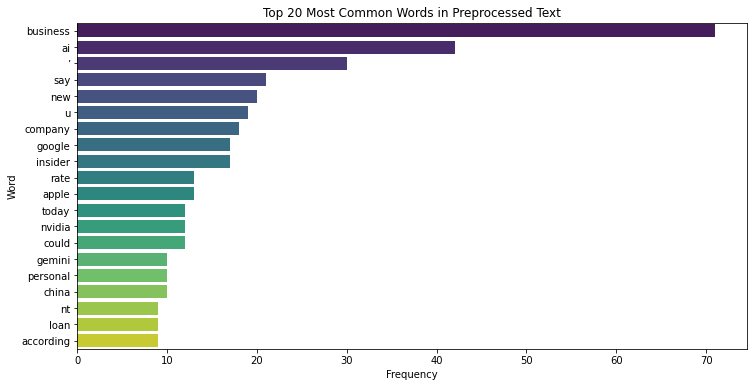

In [15]:
from collections import Counter
# Combine all preprocessed text into a single string
all_text = ' '.join(df2['title'].values + ' ' + df2['description'].values)

# Tokenize the combined text
tokens = word_tokenize(all_text)

# Count the frequency of each word
word_freq = Counter(tokens)

# Convert the word frequency to a DataFrame
word_freq_df = pd.DataFrame(list(word_freq.items()), columns=['Word', 'Frequency'])

# Sort the DataFrame by frequency in descending order
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

# Plot the top 20 most common words
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=word_freq_df.head(20), palette='viridis')
plt.title('Top 20 Most Common Words in Preprocessed Text')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

In [16]:
from transformers import pipeline, BertTokenizer, TFBertForSequenceClassification

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

# Define sentiment analysis pipeline
sentiment_analysis = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Function to perform sentiment analysis for combined text
def analyze_sentiment_for_text(text):
    """
    Analyzes the sentiment of the given text using a pre-trained BERT model for sequence classification.
    
    Parameters:
    - text: The combined text (title + description) for which sentiment analysis is to be performed.
    
    Returns:
    - A dictionary containing the sentiment analysis results:
        - 'label': The predicted sentiment label ('positive', 'negative', 'neutral').
        - 'score': The confidence score assigned to the predicted sentiment label.
    """
    # Perform sentiment analysis
    result = sentiment_analysis(text)
    
    return {'sentiment_label': result[0]['label'], 'sentiment_score': result[0]['score']}

# Combine title and description for each row and perform sentiment analysis
all_text_sentiment = []
for idx, row in df2.iterrows():
    combined_text = row['title'] + ' ' + row['description']
    sentiment_result = analyze_sentiment_for_text(combined_text)
    all_text_sentiment.append(sentiment_result)

# Add sentiment analysis results to the DataFrame
df2['sentiment_label'] = [res['sentiment_label'] for res in all_text_sentiment]
df2['sentiment_score'] = [res['sentiment_score'] for res in all_text_sentiment]

# Check if sentiment is positive for market
positive_news_for_market = df2[df2['sentiment_label'] == 'LABEL_1']
if not positive_news_for_market.empty:
    print("There are positive news for the market:")
    print(len(positive_news_for_market))
    positive_news_for_market
else:
    print("No positive news for the market.")


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


There are positive news for the market:
25


We can also use https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers=RS&apikey=XXXXXXXXXXX API to get relevant scores after sentiment analysis as follows:

<img src="Screenshot 2024-03-17 181914.png">